In [12]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [16]:
import tensorflow as tf

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [17]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/extracted_features.npy')
data.shape

data already loaded in parent notebook


(1271, 30, 63)

In [18]:
import numpy as np

def split_data(data, test_size=0.2, val_size=0.2, random_state=None):
    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(0.8 * len(unique_epoch_ids)))

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [19]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape)
print(f'test shape', X_test.shape)

train shape (992, 30, 62)
test shape (279, 30, 62)


In [20]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_test, return_counts=True)
total_samples = len(y_test)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [21]:
class_weight_dict

{0.0: 0.6428571428571429, 1.0: 2.25}

In [22]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(72, return_sequences=False))

# Fully connected layer
model.add(Dense(72, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# # Create callbacks
# callbacks = EarlyStopping(monitor='val_loss', patience=5)

In [24]:
y_train.shape

(992,)

In [25]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300,
                    validation_split = 0.2)

Epoch 1/300
8/8 [==============================] - 2s 61ms/step - loss: 0.7321 - accuracy: 0.4767 - val_loss: 0.6904 - val_accuracy: 0.6533
Epoch 2/300
8/8 [==============================] - 0s 14ms/step - loss: 0.6068 - accuracy: 0.5574 - val_loss: 0.6892 - val_accuracy: 0.7085
Epoch 3/300
8/8 [==============================] - 0s 11ms/step - loss: 0.5451 - accuracy: 0.6217 - val_loss: 0.6637 - val_accuracy: 0.7739
Epoch 4/300
8/8 [==============================] - 0s 12ms/step - loss: 0.5022 - accuracy: 0.6444 - val_loss: 0.6021 - val_accuracy: 0.9899
Epoch 5/300
8/8 [==============================] - 0s 13ms/step - loss: 0.4103 - accuracy: 0.7327 - val_loss: 0.4959 - val_accuracy: 1.0000
Epoch 6/300
8/8 [==============================] - 0s 12ms/step - loss: 0.3364 - accuracy: 0.7945 - val_loss: 0.4335 - val_accuracy: 1.0000
Epoch 7/300
8/8 [==============================] - 0s 12ms/step - loss: 0.2971 - accuracy: 0.8209 - val_loss: 0.3513 - val_accuracy: 1.0000
Epoch 8/300
8/8 [===

In [26]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

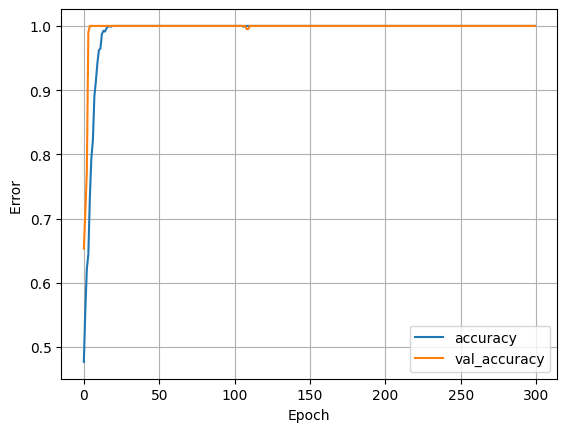

In [27]:
plot_accuracy(history)

In [55]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    # plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

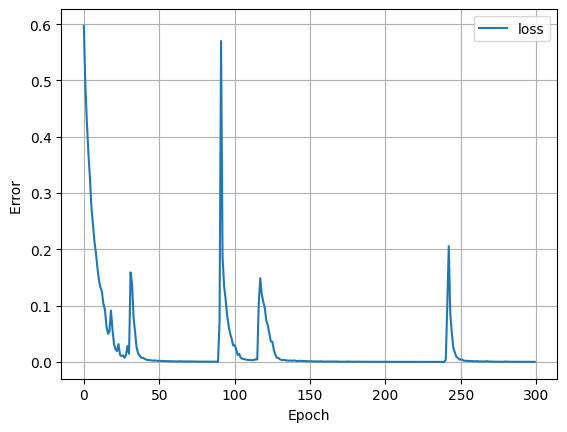

In [56]:
plot_loss(history)

In [57]:
model.evaluate(
    X_test,
    y_test, verbose=0)

[1.7675062417984009, 0.7025089859962463]

In [58]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

9/9 - 0s - loss: 1.7675 - accuracy: 0.7025 - 20ms/epoch - 2ms/step
Model accuracy: 0.7025089859962463


In [59]:
y_pred_train = model.predict(X_train)
y_pred_train

31/31 [==============================] - 0s 1ms/step


array([[4.69420447e-05],
       [1.44597550e-04],
       [1.15141695e-04],
       [6.54198957e-05],
       [3.30377952e-05],
       [1.95380308e-05],
       [8.28901830e-05],
       [3.13518249e-05],
       [5.69612312e-05],
       [1.45707862e-04],
       [3.98721721e-04],
       [2.44068928e-04],
       [4.19235876e-04],
       [2.27488010e-04],
       [1.49456842e-04],
       [8.99760562e-05],
       [5.71699988e-04],
       [6.40957500e-04],
       [3.17510596e-04],
       [3.31808296e-05],
       [1.24238271e-04],
       [1.35920300e-06],
       [2.91296374e-07],
       [3.88892586e-05],
       [2.97101506e-04],
       [9.14239965e-04],
       [1.33202190e-03],
       [1.25032966e-03],
       [6.97755779e-04],
       [1.34342082e-03],
       [1.35973026e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.00000000e+00],
       [9.99999940e-01],
       [9.99995172e-01],
       [9.99982953e-01],
       [9.99988258e-01],


In [60]:
# plt.figure(figsize=(15,10))  # Adjust the width and height as needed
# plt.plot(y_pred_train[:200])
# plt.plot(y_train[:200])


In [61]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

9/9 [==============================] - 0s 1ms/step


(279, 1)

In [62]:
# plt.figure(figsize=(15,10))  
# plt.plot(y_pred[:200])
# plt.plot(y_test[:200])

In [63]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

9/9 [==============================] - 0s 1ms/step - loss: 1.7675 - accuracy: 0.7025
Loss: 1.7675062417984009
Accuracy: 0.7025089859962463
Precision: 0.3090909090909091
Recall: 0.27419354838709675


(62.0, 55)

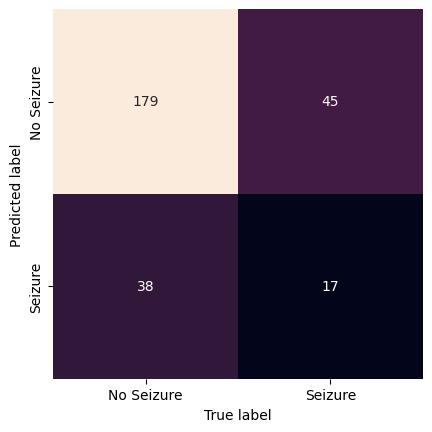

In [64]:
from sklearn.metrics import confusion_matrix, classification_report
mat = confusion_matrix(y_test, y_pred_c)
labels = ['No Seizure', 'Seizure']
# Create the heatmap with custom labels
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel('True label')
plt.ylabel('Predicted label')

plt.show()

In [65]:
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       217
         1.0       0.31      0.27      0.29        62

    accuracy                           0.70       279
   macro avg       0.55      0.55      0.55       279
weighted avg       0.69      0.70      0.70       279



Text(0, 0.5, 'Predictions')

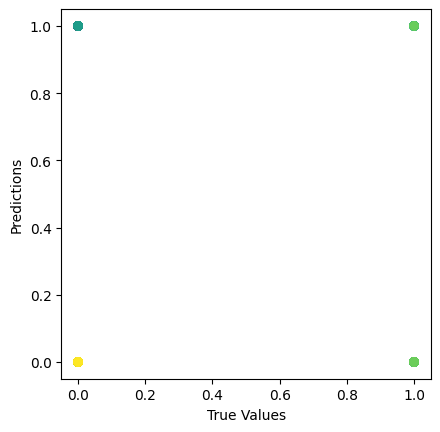

In [66]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_c,c=np.arange(len(y_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

In [67]:
# error = y_pred_c - y_test
# plt.hist(error, bins=25)
# plt.xlabel('Prediction Error')
# _ = plt.ylabel('Count')

In [68]:
# def make_model(input_shape):
#     input_layer = keras.layers.Input(input_shape)

#     conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
#     conv1 = keras.layers.BatchNormalization()(conv1)
#     conv1 = keras.layers.ReLU()(conv1)

#     conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
#     conv2 = keras.layers.BatchNormalization()(conv2)
#     conv2 = keras.layers.ReLU()(conv2)

#     conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
#     conv3 = keras.layers.BatchNormalization()(conv3)
#     conv3 = keras.layers.ReLU()(conv3)

#     gap = keras.layers.GlobalAveragePooling1D()(conv3)

#     output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

#     return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [69]:
# model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [70]:
# epochs = 500
# batch_size = 32

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         "best_model.h5", save_best_only=True, monitor="val_loss"
#     ),
#     keras.callbacks.ReduceLROnPlateau(
#         monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
#     ),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
# ]
# model.compile(
#     optimizer="adam",
#     loss="sparse_categorical_crossentropy",
#     metrics=["sparse_categorical_accuracy"],
# )
# history = model.fit(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     #validation_split=0.2,
#     verbose=1,


inputs: A 3D tensor with shape [batch, timesteps, feature].

In [71]:
# Define a sequential model
model = keras.Sequential()

#model.add(normalizer)

# Add an input layer with an input shape of (time_steps, input_features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# Add a SimpleRNN layer with 32 units (neurons)
model.add(layers.SimpleRNN(72, activation='tanh'))

model.add(BatchNormalization())

# Add the output layer with 1 neuron and sigmoid activation for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model with binary cross-entropy loss for binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [72]:
X_train.shape

(992, 30, 62)

In [73]:
y_train.shape

(992,)

In [74]:
history = model.fit(X_train,  y_train, 
                    batch_size=100, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=300)

Epoch 1/300
10/10 [==============================] - 1s 4ms/step - loss: 0.6690 - accuracy: 0.6321
Epoch 2/300
10/10 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.7409
Epoch 3/300
10/10 [==============================] - 0s 4ms/step - loss: 0.3952 - accuracy: 0.8085
Epoch 4/300
10/10 [==============================] - 0s 3ms/step - loss: 0.3347 - accuracy: 0.8599
Epoch 5/300
10/10 [==============================] - 0s 3ms/step - loss: 0.3005 - accuracy: 0.8800
Epoch 6/300
10/10 [==============================] - 0s 3ms/step - loss: 0.2530 - accuracy: 0.9073
Epoch 7/300
10/10 [==============================] - 0s 3ms/step - loss: 0.2278 - accuracy: 0.9133
Epoch 8/300
10/10 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9234
Epoch 9/300
10/10 [==============================] - 0s 3ms/step - loss: 0.1809 - accuracy: 0.9264
Epoch 10/300
10/10 [==============================] - 0s 3ms/step - loss: 0.1613 - accuracy: 0.9304
Epoch 11/

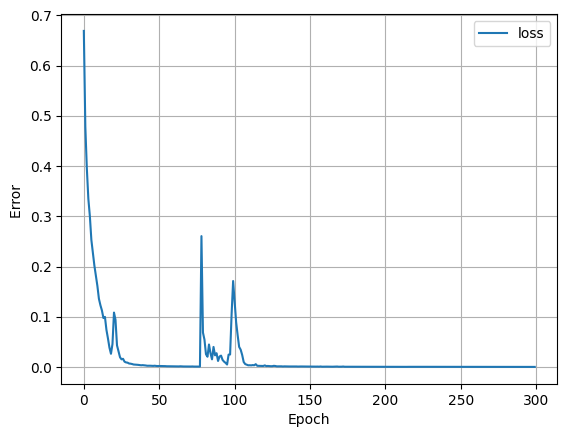

In [75]:
plot_loss(history)

In [76]:
y_pred = model.predict(X_test).flatten()
y_pred

9/9 [==============================] - 0s 2ms/step


array([1.34688125e-05, 3.99867073e-02, 2.06959317e-04, 2.26878459e-04,
       1.26482907e-03, 4.04428487e-04, 3.39684542e-04, 5.15728840e-04,
       4.12392401e-04, 8.29299213e-04, 9.70914436e-04, 1.22596615e-03,
       1.42490247e-03, 2.15187250e-03, 5.44217415e-04, 7.25656108e-04,
       9.36824013e-04, 1.24565815e-03, 1.34253120e-02, 4.25574544e-04,
       2.91840755e-04, 1.50332076e-03, 4.52248566e-03, 7.03251967e-03,
       1.33089460e-02, 2.29047425e-02, 7.01306434e-03, 5.50827337e-03,
       1.77055299e-02, 3.65027897e-02, 1.42483357e-02, 1.22629790e-04,
       9.72885537e-05, 3.01017462e-06, 3.63177569e-05, 9.92015412e-05,
       1.43061799e-04, 2.54240097e-03, 2.05197764e-04, 3.02330242e-04,
       1.06263971e-04, 1.38243660e-04, 1.75619949e-04, 1.91153697e-04,
       1.36545510e-04, 1.12727059e-04, 1.65157384e-04, 1.71129097e-04,
       2.03947464e-04, 2.04108146e-04, 2.88532465e-04, 3.84516548e-04,
       1.23166406e-04, 1.96936264e-04, 3.19005543e-04, 1.73540175e-04,
      

In [77]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {accuracy}')

9/9 - 0s - loss: 1.7901 - accuracy: 0.7670 - 128ms/epoch - 14ms/step
Model accuracy: 0.7670251131057739


In [78]:
from sklearn.metrics import precision_score, recall_score
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

loss, accuracy = model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()

9/9 [==============================] - 0s 2ms/step - loss: 1.7901 - accuracy: 0.7670
Loss: 1.7901027202606201
Accuracy: 0.7670251131057739
Precision: 0.4482758620689655
Recall: 0.20967741935483872


(62.0, 29)

Text(0, 0.5, 'Predictions')

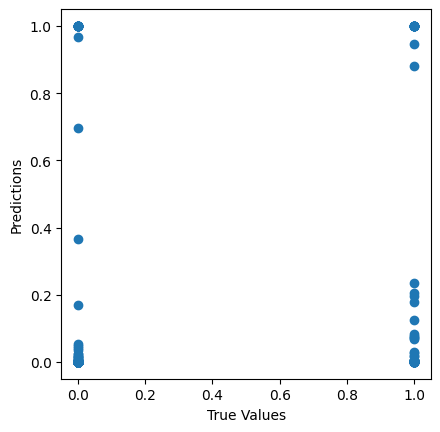

In [79]:

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')